In [4]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import random
from PIL import Image

In [5]:
df_poke = pd.read_csv("data/pokemon.csv")
df_poke

,Name,Type1,Type2
0,bulbasaur,Grass,Poison
1,ivysaur,Grass,Poison
2,venusaur,Grass,Poison
3,charmander,Fire,NaN
4,charmeleon,Fire,NaN
...,...,...,...
804,stakataka,Rock,Steel
805,blacephalon,Fire,Ghost
806,zeraora,Electric,NaN
807,meltan,Steel,NaN


In [6]:
pokemon_type_list = df_poke["Type1"].unique().tolist()
pokemon_type_list.remove("Flying")

type_to_pokemon_list = {}

for pokemon_type in pokemon_type_list :
    type_to_pokemon_list[pokemon_type] = []

for _, row in df_poke.iterrows():
    pokemon_name = row[0]
    pokemon_type1 = row[1]
    
    if pokemon_type1 != "Flying":
        type_to_pokemon_list[pokemon_type1].append(pokemon_name)

type_to_pokemon_list

{'Grass': ['bulbasaur',
  'ivysaur',
  'venusaur',
  'oddish',
  'gloom',
  'vileplume',
  'bellsprout',
  'weepinbell',
  'victreebel',
  'exeggcute',
  'exeggutor',
  'tangela',
  'chikorita',
  'bayleef',
  'meganium',
  'bellossom',
  'hoppip',
  'skiploom',
  'jumpluff',
  'sunkern',
  'sunflora',
  'treecko',
  'grovyle',
  'sceptile',
  'seedot',
  'nuzleaf',
  'shiftry',
  'shroomish',
  'breloom',
  'roselia',
  'cacnea',
  'cacturne',
  'tropius',
  'turtwig',
  'grotle',
  'torterra',
  'budew',
  'roserade',
  'cherubi',
  'cherrim',
  'carnivine',
  'snover',
  'abomasnow',
  'tangrowth',
  'leafeon',
  'shaymin-land',
  'snivy',
  'servine',
  'serperior',
  'pansage',
  'simisage',
  'cottonee',
  'whimsicott',
  'petilil',
  'lilligant',
  'maractus',
  'foongus',
  'amoonguss',
  'ferroseed',
  'ferrothorn',
  'virizion',
  'chespin',
  'quilladin',
  'chesnaught',
  'skiddo',
  'gogoat',
  'rowlet',
  'dartrix',
  'decidueye',
  'fomantis',
  'lurantis',
  'morelull',

In [7]:
def mean_std_transfer(img_arr_in=None, img_arr_ref=None):
    mean_in = np.ma.array(img_arr_in, mask=img_arr_in[:,:] == np.array([255,128,128])).mean(axis=(0, 1), keepdims=True)
    mean_ref = np.ma.array(img_arr_ref, mask=img_arr_ref[:,:] == np.array([255,128,128])).mean(axis=(0, 1), keepdims=True)
    std_in = np.ma.array(img_arr_in, mask=img_arr_in[:,:] == np.array([255,128,128])).std(axis=(0, 1), keepdims=True)
    std_ref = np.ma.array(img_arr_ref, mask=img_arr_ref[:,:] == np.array([255,128,128])).std(axis=(0, 1), keepdims=True)
    img_arr_out = (img_arr_in - mean_in) / std_in * std_ref + mean_ref
    # img_arr_out = img_arr_in.copy()
    # img_arr_out[:, :, 1:] = (img_arr_in[:, :, 1:] - mean_in[:, :, 1:]) / std_in[:, :, 1:] * std_ref[:, :, 1:] + mean_ref[:, :, 1:]
    img_arr_out[img_arr_out < 0] = 0
    img_arr_out[img_arr_out > 255] = 255
    img_arr_out = np.where(img_arr_in[:,:] == np.array([255,128,128]), np.array([255,128,128]), img_arr_out[:,:])
    # img_arr_out = np.where(img_arr_in[:,:] == np.array([0,0,0]), np.array([0,0,0]), img_arr_out[:,:])
    return img_arr_out.astype(np.uint8)

In [8]:
def lab_transfer(img_arr_in=None, img_arr_ref=None):
        """ Since the RGB colour space is highly correlated, 
        the transfer is done in another colour space [4]
        """
        
        lab_in = cv2.cvtColor(img_arr_in, cv2.COLOR_RGB2LAB)
        lab_ref = cv2.cvtColor(img_arr_ref, cv2.COLOR_RGB2LAB)
        lab_out = mean_std_transfer(img_arr_in=lab_in, img_arr_ref=lab_ref)
        img_arr_out = cv2.cvtColor(lab_out, cv2.COLOR_LAB2RGB)
        return img_arr_out

def mean_std_transfer_no_white(img_arr_in=None, img_arr_ref=None):
    mean_in = np.mean(img_arr_in, axis=(0, 1), keepdims=True)
    mean_ref = np.mean(img_arr_ref, axis=(0, 1), keepdims=True)
    std_in = np.std(img_arr_in, axis=(0, 1), keepdims=True)
    std_ref = np.std(img_arr_ref, axis=(0, 1), keepdims=True)
    img_arr_out = (img_arr_in - mean_in) / std_in * std_ref + mean_ref
    img_arr_out[img_arr_out < 0] = 0
    img_arr_out[img_arr_out > 255] = 255
    return img_arr_out.astype("uint8")

def lab_transfer_no_white(img_arr_in=None, img_arr_ref=None):

    lab_in = cv2.cvtColor(img_arr_in, cv2.COLOR_RGB2LAB)
    lab_ref = cv2.cvtColor(img_arr_ref, cv2.COLOR_RGB2LAB)
    lab_out = mean_std_transfer_no_white(img_arr_in=lab_in, img_arr_ref=lab_ref)
    img_arr_out = cv2.cvtColor(lab_out, cv2.COLOR_LAB2RGB)
    return img_arr_out

In [10]:
from utils import Rotations

def pdf_transfer(img_arr_in=None, img_arr_ref=None):

    # reshape (h, w, c) to (c, h*w)
    [h, w, c] = img_arr_in.shape
    reshape_arr_in = img_arr_in.reshape(-1, c).transpose() / 255.0
    reshape_arr_ref = img_arr_ref.reshape(-1, c).transpose() / 255.0
    # pdf transfer
    reshape_arr_out = pdf_transfer_nd(
        arr_in=reshape_arr_in, arr_ref=reshape_arr_ref
    )
    # reshape (c, h*w) to (h, w, c)
    reshape_arr_out[reshape_arr_out < 0] = 0
    reshape_arr_out[reshape_arr_out > 1] = 1
    reshape_arr_out = (255.0 * reshape_arr_out).astype("uint8")
    img_arr_out = reshape_arr_out.transpose().reshape(h, w, c)
    img_arr_out = np.where(img_arr_in[:,:] == np.array([255,255,255]), np.array([255,255,255]), img_arr_out[:,:])
    img_arr_out = np.where(img_arr_in[:,:] == np.array([0,0,0]), np.array([0,0,0]), img_arr_out[:,:])

    img_arr_out = img_arr_out.astype(np.uint8)

    return img_arr_out

def pdf_transfer_nd(arr_in=None, arr_ref=None, step_size=1):

    # n times of 1d-pdf-transfer
    arr_out = np.array(arr_in)
    for rotation_matrix in Rotations.optimal_rotations():
        rot_arr_in = np.matmul(rotation_matrix, arr_out)
        rot_arr_ref = np.matmul(rotation_matrix, arr_ref)
        rot_arr_out = np.zeros(rot_arr_in.shape)
        for i in range(rot_arr_out.shape[0]):
            rot_arr_out[i] = pdf_transfer_1d(rot_arr_in[i], rot_arr_ref[i])

        rot_delta_arr = rot_arr_out - rot_arr_in
        delta_arr = np.matmul(
            rotation_matrix.transpose(), rot_delta_arr
        )  
        arr_out = step_size * delta_arr + arr_out
    return arr_out

def pdf_transfer_1d(arr_in=None, arr_ref=None):

    eps = 1e-6
    n = 1000

    arr = np.concatenate((arr_in, arr_ref))
    # discretization as histogram
    min_v = arr.min() - eps
    max_v = arr.max() + eps
    xs = np.array([min_v + (max_v - min_v) * i / n for i in range(n + 1)])
    hist_in, _ = np.histogram(arr_in, xs)
    hist_ref, _ = np.histogram(arr_ref, xs)
    xs = xs[:-1]
    # compute probability distribution
    cum_in = np.cumsum(hist_in)
    cum_ref = np.cumsum(hist_ref)
    d_in = cum_in / cum_in[-1]
    d_ref = cum_ref / cum_ref[-1]
    # tranfer
    t_d_in = np.interp(d_in, d_ref, xs)
    t_d_in[d_in <= d_ref[0]] = min_v
    t_d_in[d_in >= d_ref[-1]] = max_v
    arr_out = np.interp(arr_in, xs, t_d_in)
    return arr_out

In [11]:
IMAGE_DIR = "data/pokemon_png"

In [12]:
def create_average_image(type, type_to_pokemon_list, in_img, pokemon_name, transfer_function):
    if pokemon_name in type_to_pokemon_list[type]:
        return in_img 
    else:
        img_list = []
        pokemon_list = type_to_pokemon_list[type]
        for pokemon_name_ref in pokemon_list:
            try:
                ref_img = cv2.imread(IMAGE_DIR + "/" + pokemon_name_ref + ".png")
                ref_img = cv2.cvtColor(ref_img, cv2.COLOR_BGR2RGB)
                img_list.append(transfer_function(in_img, ref_img))
            except:
                pass
        l = len(img_list)
        avg = Image.fromarray(img_list[0], 'RGB')
        for i in range(1, l):
            avg = Image.blend(avg, Image.fromarray(img_list[i], 'RGB'), 1.0/(i+1))
        return np.array(avg).astype(np.uint8)


In [13]:
def reset_l_channel(img_in, img_out):
    """input images must be RGB"""

    res = cv2.cvtColor(img_out, cv2.COLOR_RGB2LAB)

    i_in = cv2.cvtColor(img_in, cv2.COLOR_RGB2LAB)

    res[:,:,0] = i_in[:,:,0]

    res = cv2.cvtColor(res, cv2.COLOR_LAB2RGB)

    return res
    

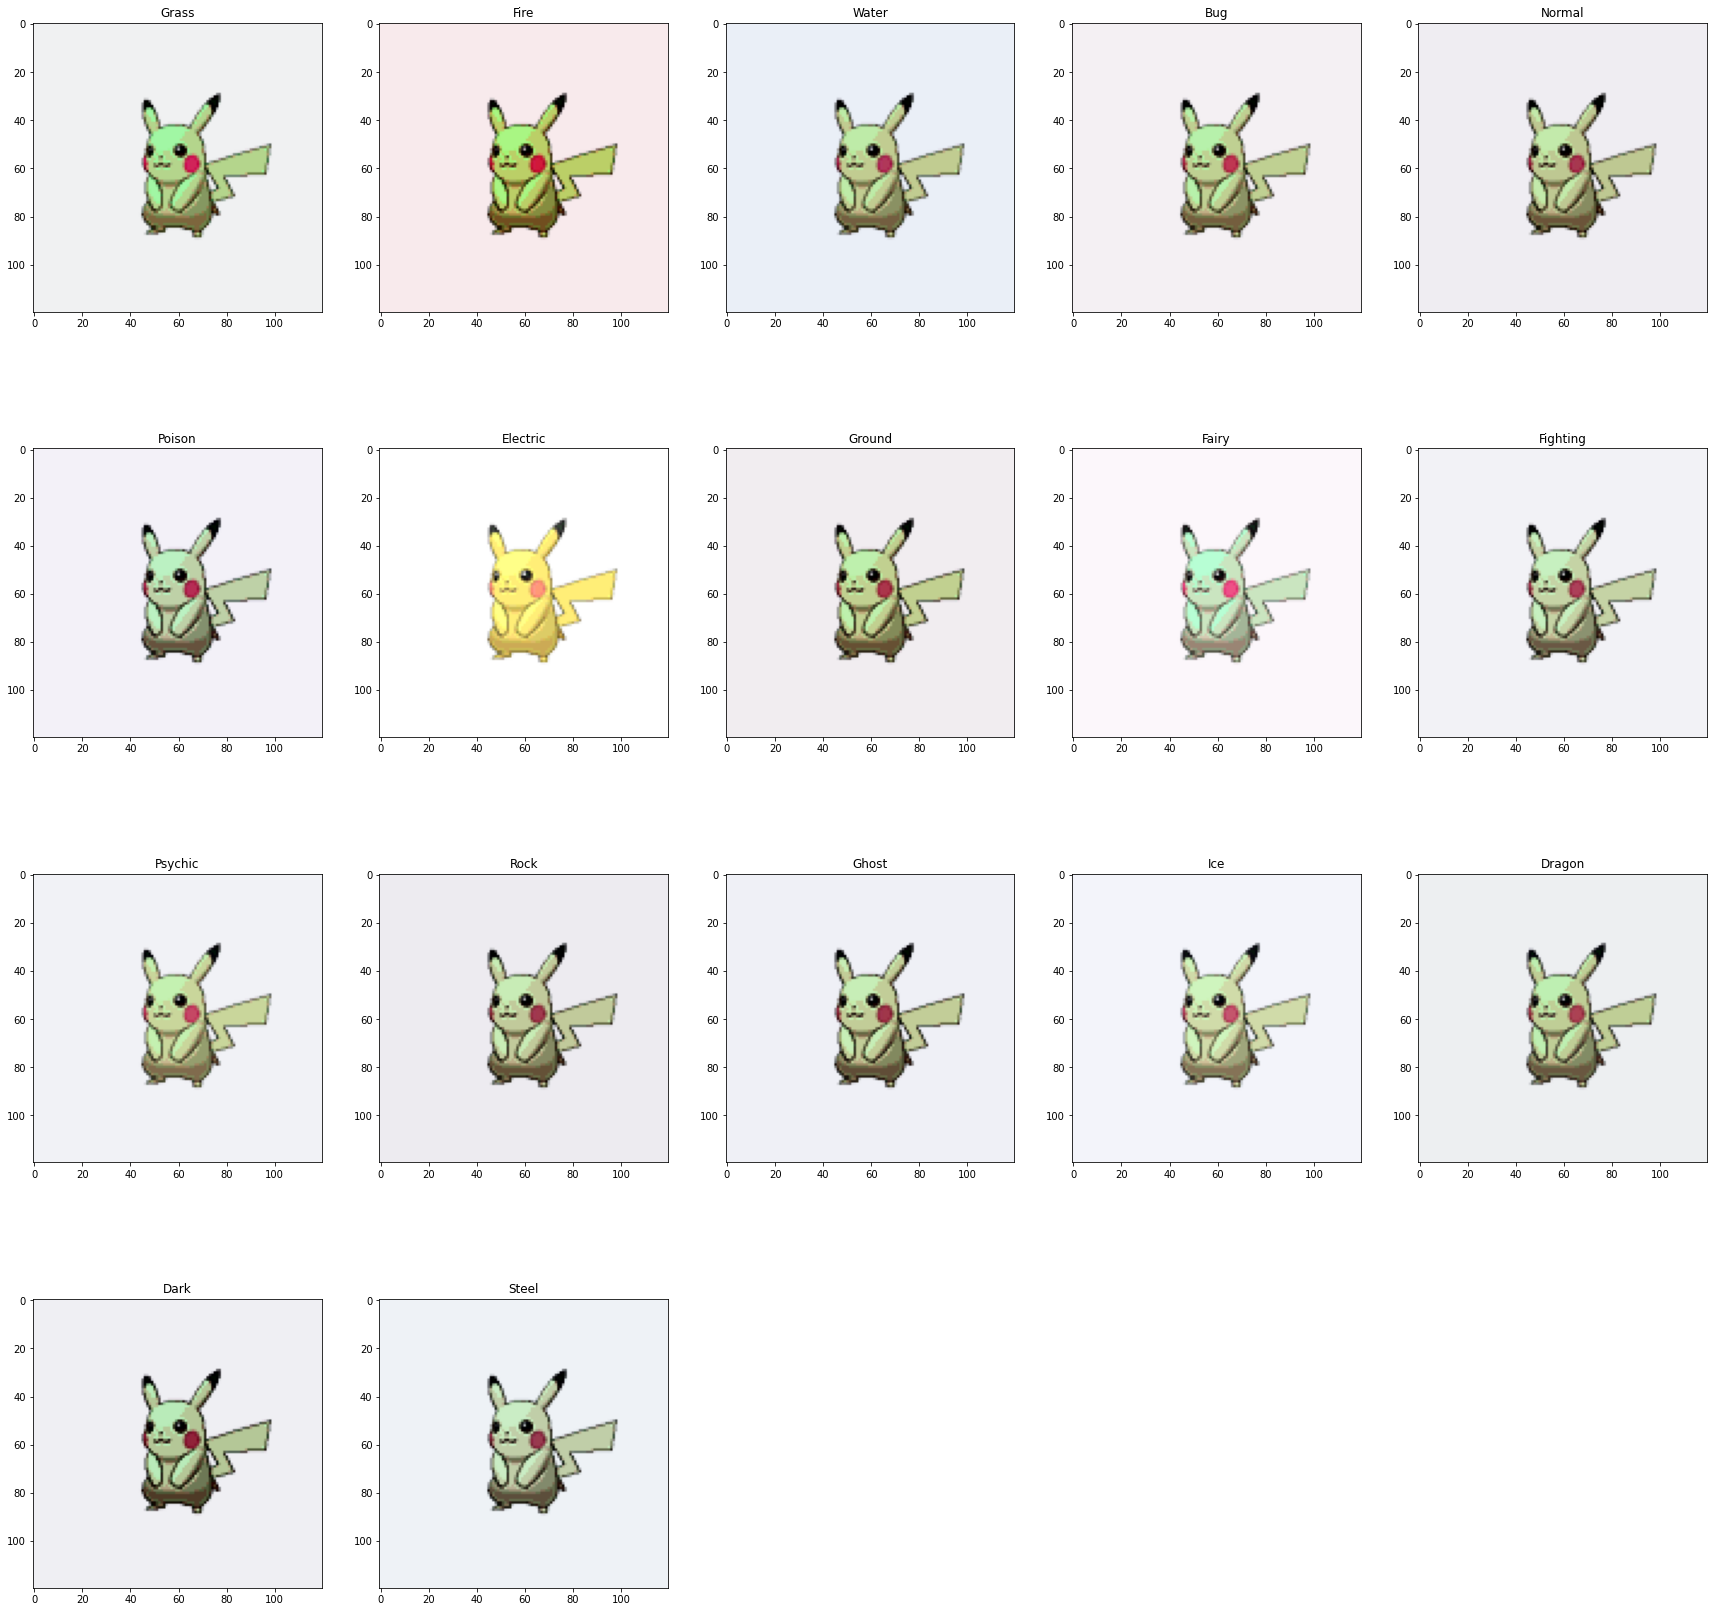

In [14]:
pokemon_name = "pikachu"

in_img = cv2.imread(IMAGE_DIR + "/" + pokemon_name + ".png")
in_img = cv2.cvtColor(in_img, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots(4,5, figsize = (30,30))

x = 0
y = 0
for _, type in enumerate(list(type_to_pokemon_list.keys())):

    average_img = create_average_image(type, type_to_pokemon_list, in_img, pokemon_name, lab_transfer_no_white)

    ax[x,y].imshow(average_img)
    ax[x,y].title.set_text(type)

    y = (y + 1) % 5
    if y == 0:
        x = (x + 1) % 4

for y in range(1,4):
    fig.delaxes(ax[3,-y])

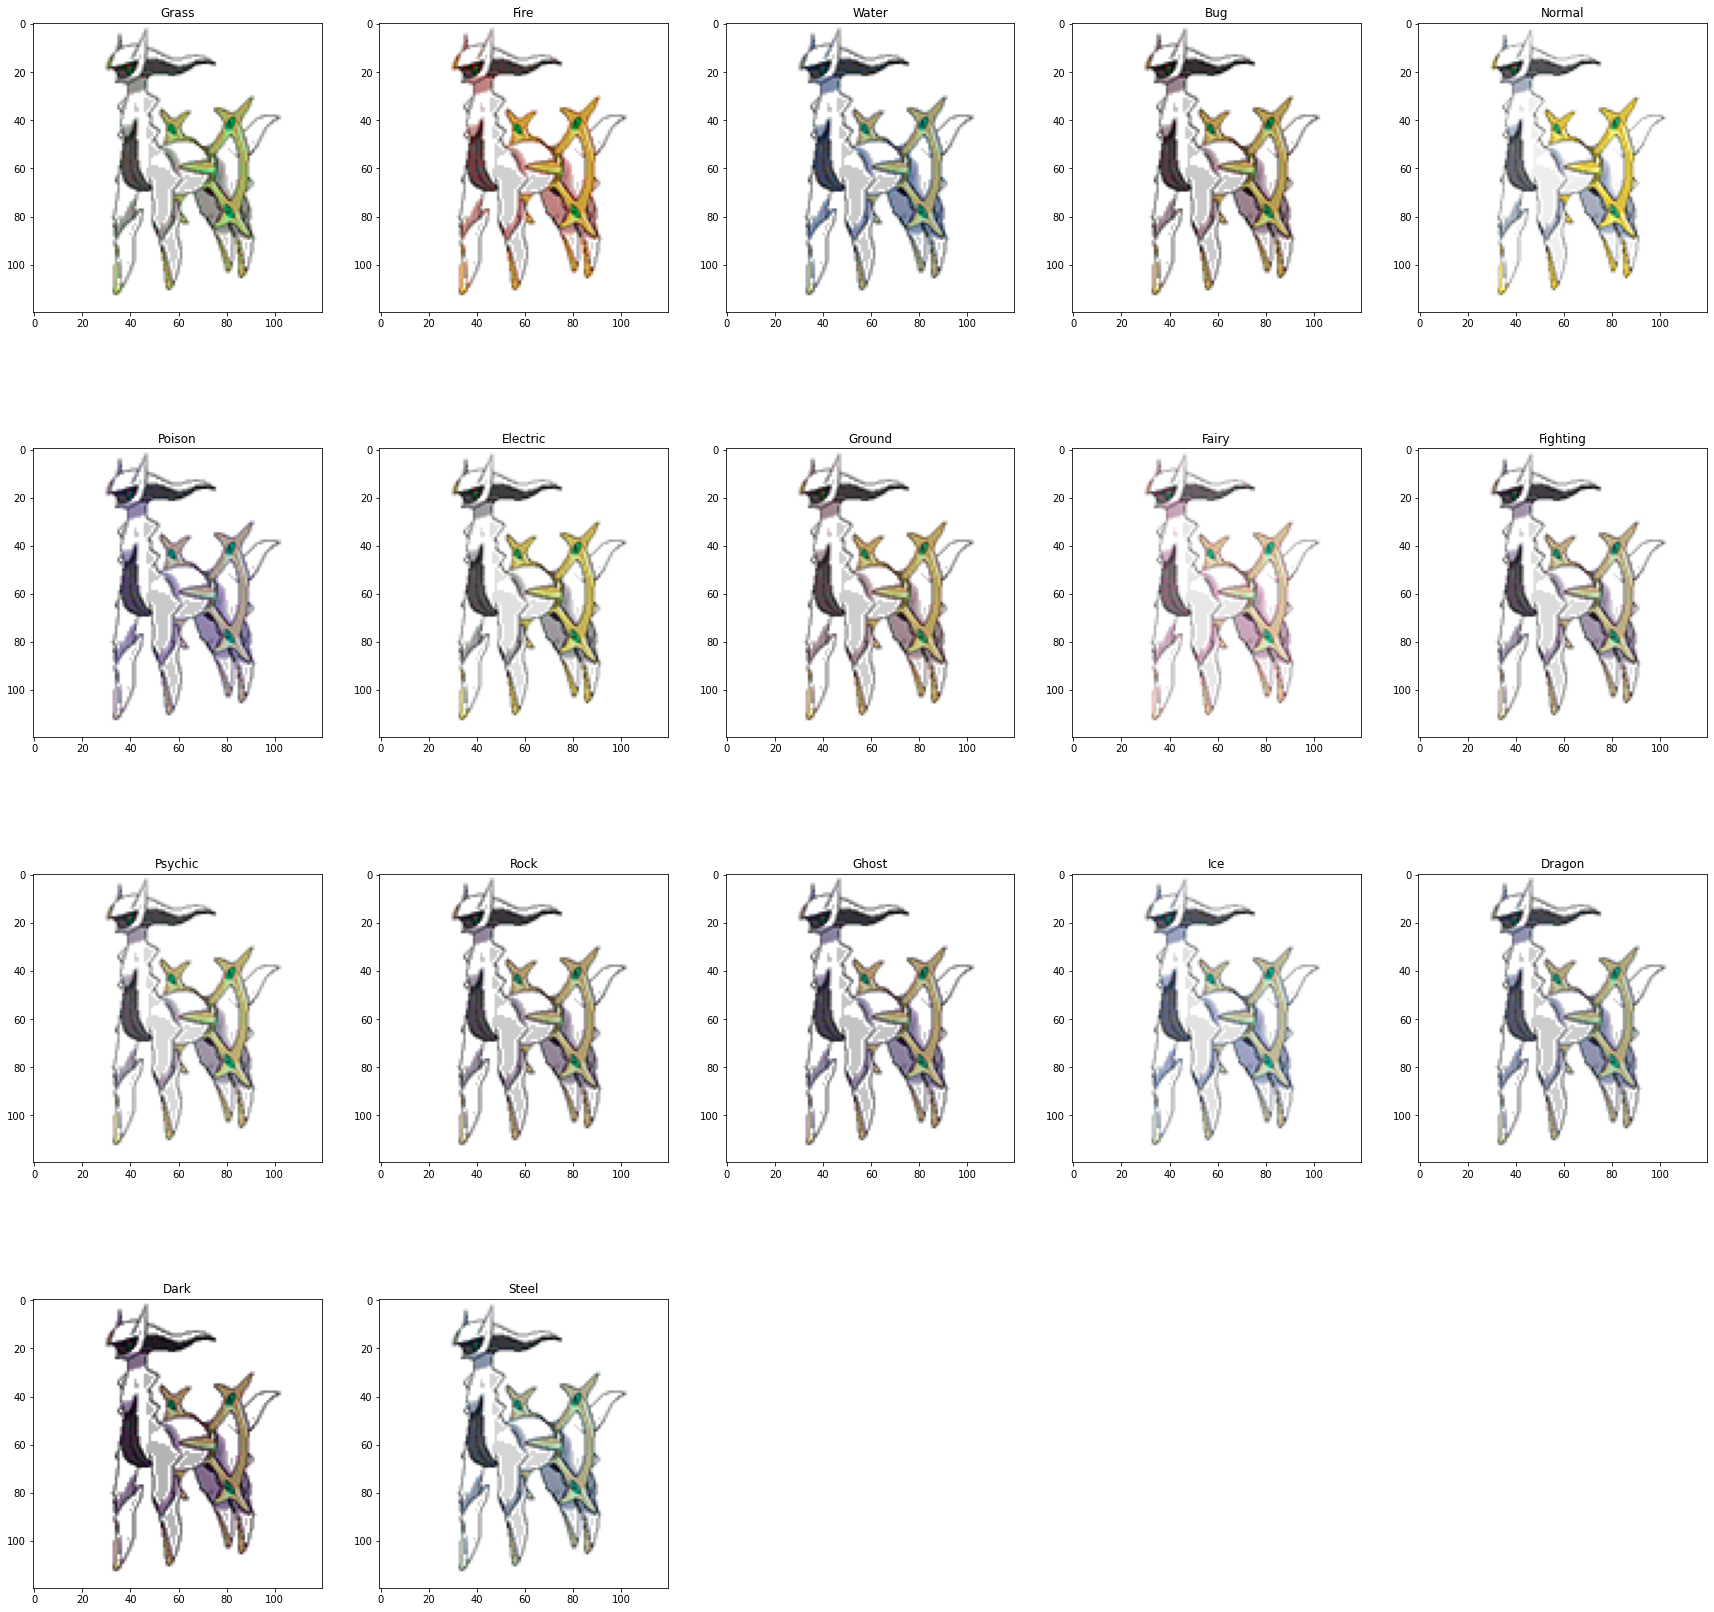

In [15]:
pokemon_name = "arceus"

in_img = cv2.imread(IMAGE_DIR + "/" + pokemon_name + ".png")
in_img = cv2.cvtColor(in_img, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots(4,5, figsize = (30,30))

x = 0
y = 0
for _, type in enumerate(list(type_to_pokemon_list.keys())):

    average_img = create_average_image(type, type_to_pokemon_list, in_img, pokemon_name, lab_transfer)
    
    ax[x,y].imshow(average_img)
    ax[x,y].title.set_text(type)

    y = (y + 1) % 5
    if y == 0:
        x = (x + 1) % 4

for y in range(1,4):
    fig.delaxes(ax[3,-y])

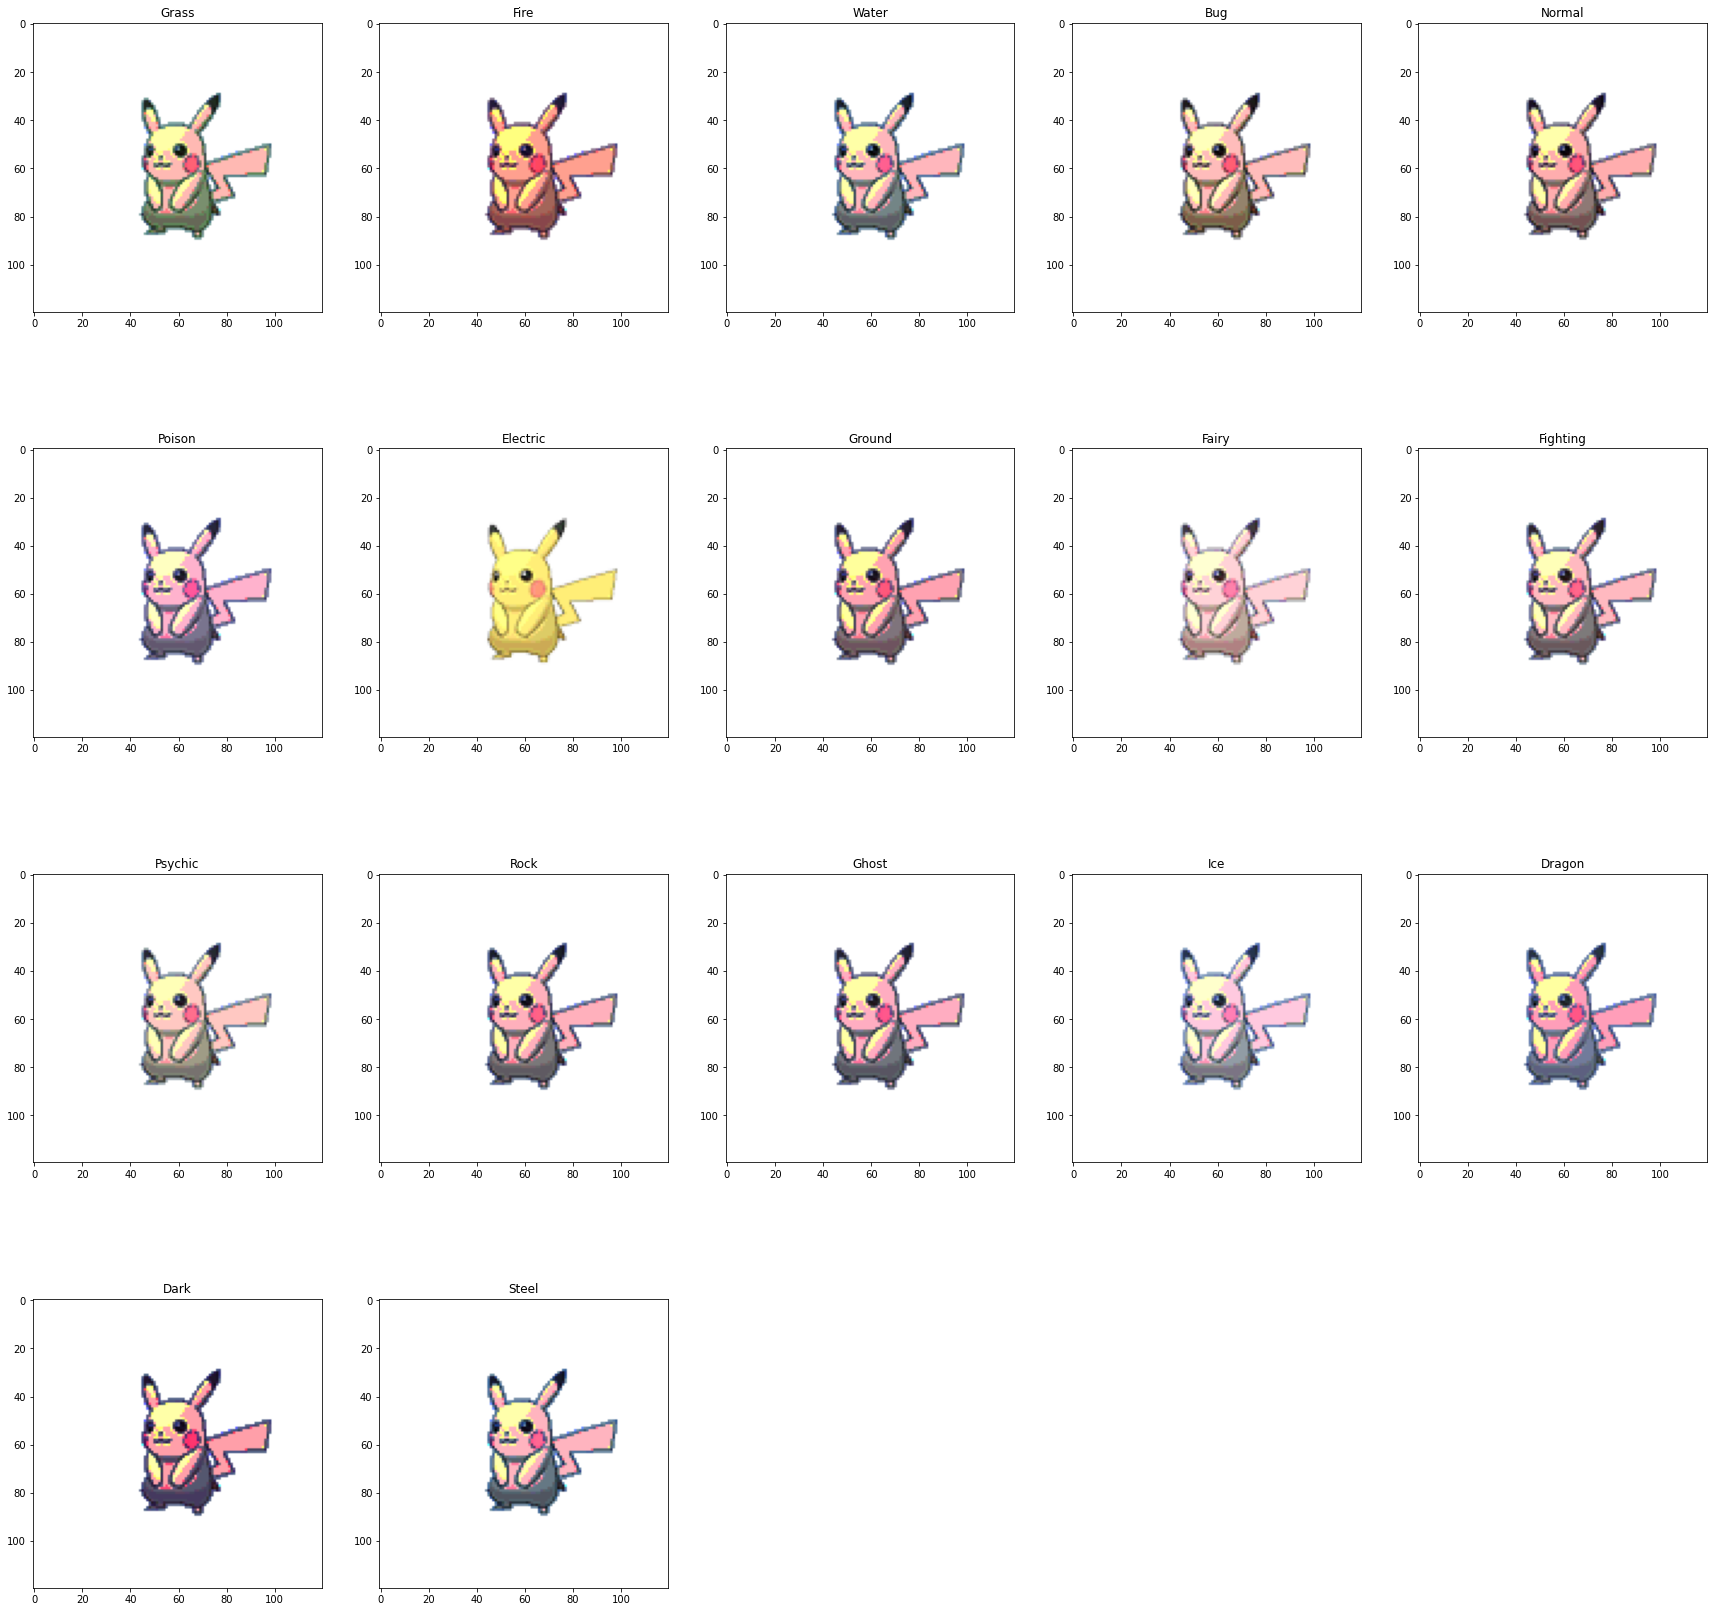

In [16]:
pokemon_name = "pikachu"

in_img = cv2.imread(IMAGE_DIR + "/" + pokemon_name + ".png")
in_img = cv2.cvtColor(in_img, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots(4,5, figsize = (30,30))

x = 0
y = 0
for _, type in enumerate(list(type_to_pokemon_list.keys())):

    average_img = create_average_image(type, type_to_pokemon_list, in_img, pokemon_name, pdf_transfer)
    
    ax[x,y].imshow(average_img)
    ax[x,y].title.set_text(type)

    y = (y + 1) % 5
    if y == 0:
        x = (x + 1) % 4

for y in range(1,4):
    fig.delaxes(ax[3,-y])

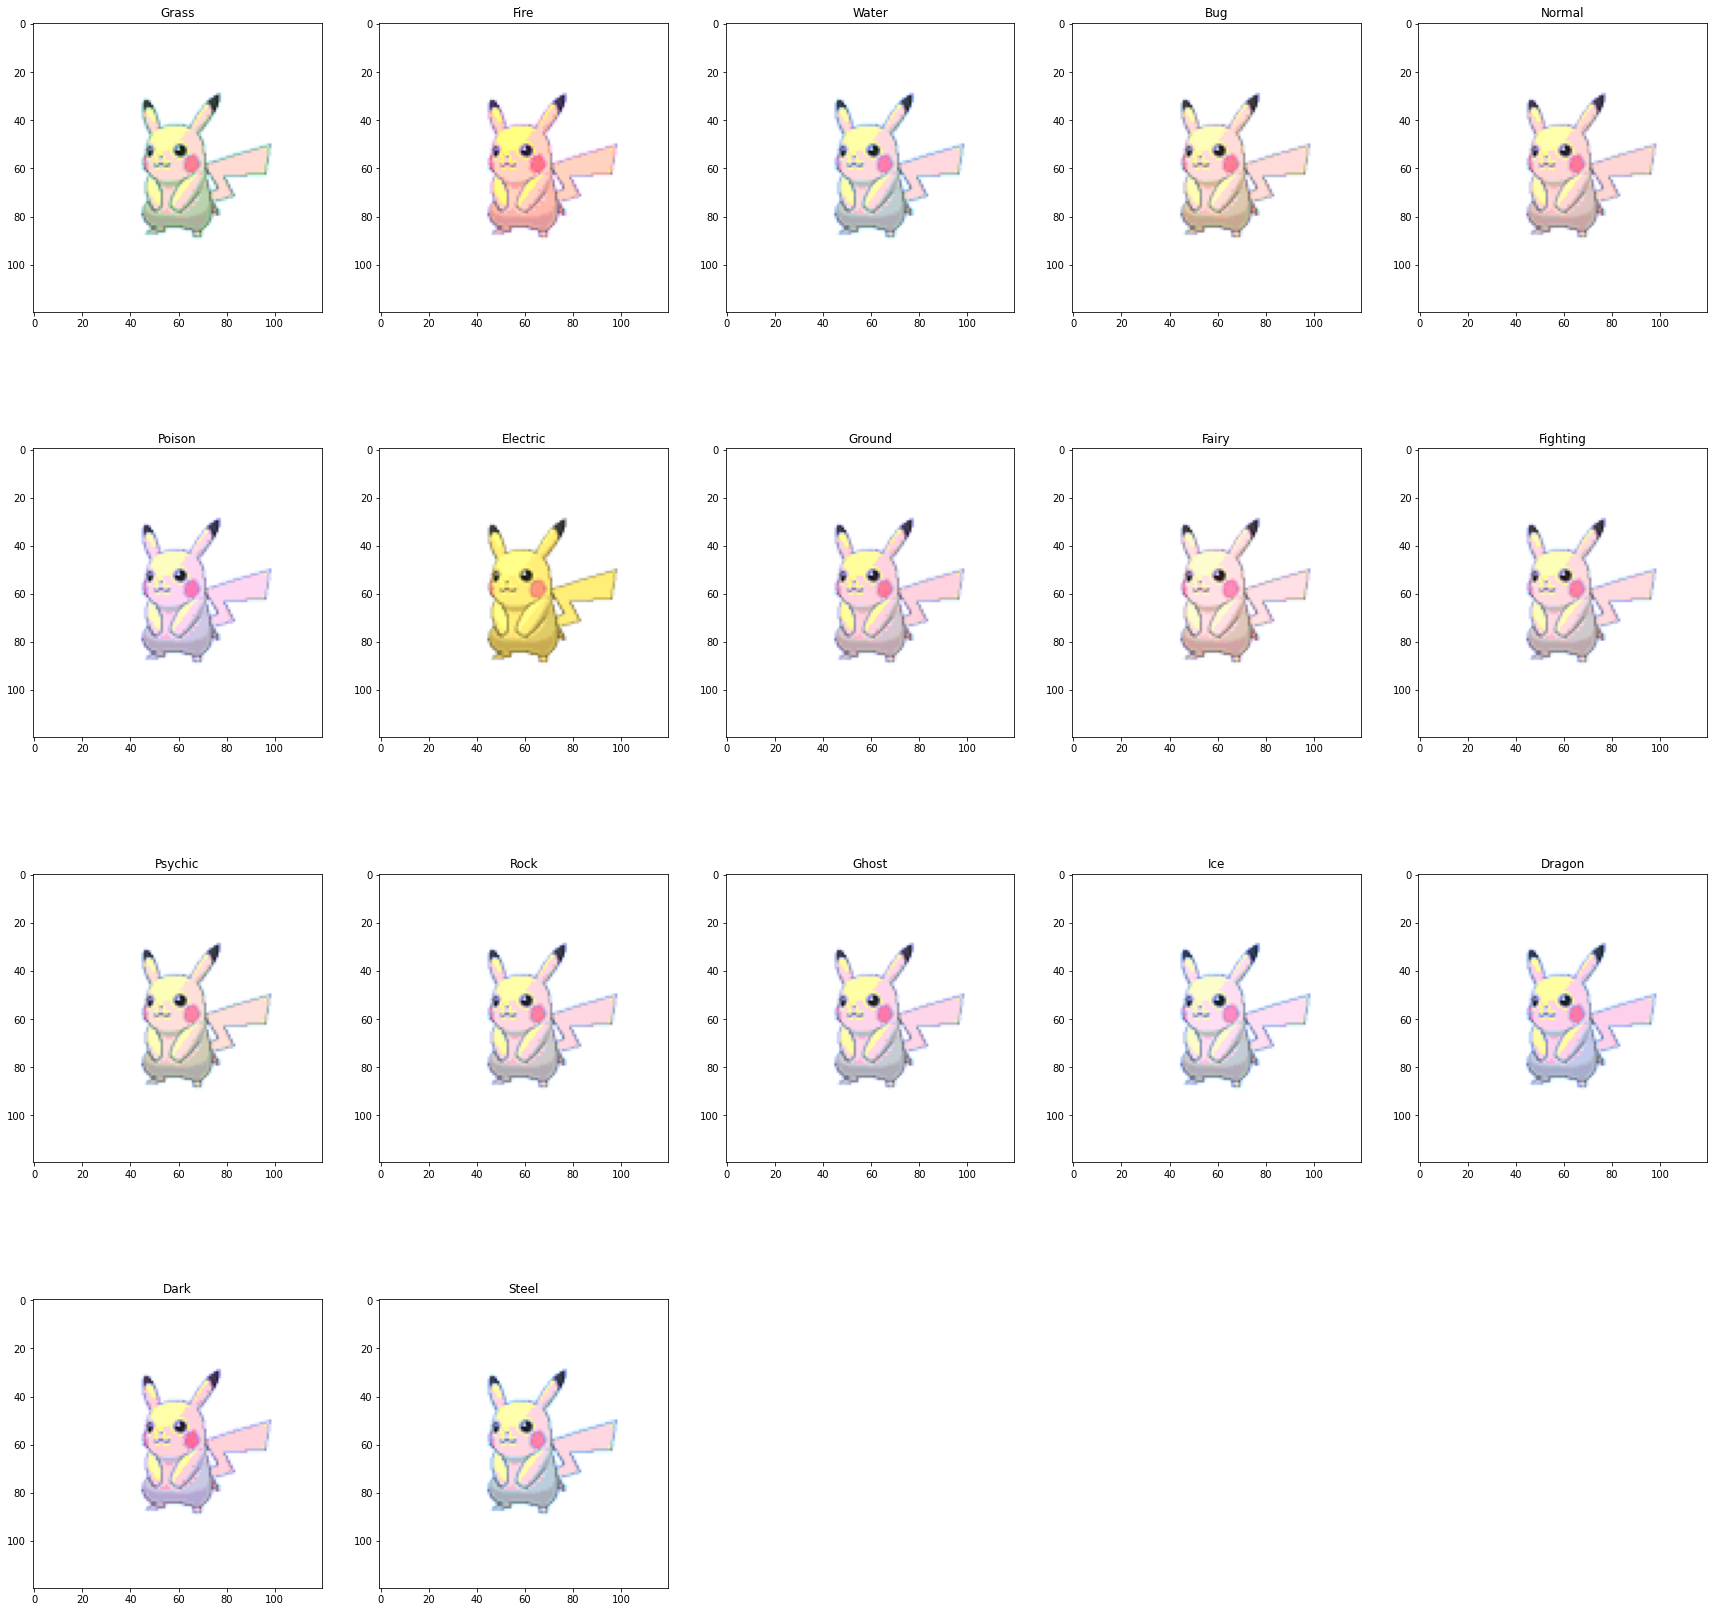

In [17]:
pokemon_name = "pikachu"

in_img = cv2.imread(IMAGE_DIR + "/" + pokemon_name + ".png")
in_img = cv2.cvtColor(in_img, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots(4,5, figsize = (30,30))

x = 0
y = 0
for _, type in enumerate(list(type_to_pokemon_list.keys())):

    average_img = create_average_image(type, type_to_pokemon_list, in_img, pokemon_name, pdf_transfer)

    average_img = reset_l_channel(in_img, average_img)
    
    ax[x,y].imshow(average_img)
    ax[x,y].title.set_text(type)

    y = (y + 1) % 5
    if y == 0:
        x = (x + 1) % 4

for y in range(1,4):
    fig.delaxes(ax[3,-y])

In [46]:
def my_colorplot(df_orig, df_target, df_result, bins=100, size=3):
    colors = zip(
        df_orig.columns[:-1],
        df_orig.columns[1:],
    )
    color_pairs = list(combinations(colors, 2))
    
    nrows = len(color_pairs)
    
    figsize = (3*size, nrows*size)
    
    x_lim = np.empty((3, 2))
    y_lim = np.empty((3, 2))
    
    fig, ax = plt.subplots(nrows, 3, figsize=figsize)
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    if nrows == 1:
        ax = [ax]
    
    for i, (a, b) in enumerate(color_pairs):
        ax[i][0].hist2d(
            df_orig[a[0]] - df_orig[a[1]],
            df_orig[b[0]] - df_orig[b[1]],
            bins=bins, norm=mpl.colors.LogNorm()
        )
        x_lim[0] = ax[i][0].get_xlim()
        y_lim[0] = ax[i][0].get_ylim()
        
        ax[i][1].hist2d(
            df_target[a[0]] - df_target[a[1]],
            df_target[b[0]] - df_target[b[1]],
            bins=bins, norm=mpl.colors.LogNorm()
        )
        x_lim[1] = ax[i][1].get_xlim()
        y_lim[1] = ax[i][1].get_ylim()
        
        ax[i][2].hist2d(
            df_result[a[0]] - df_result[a[1]],
            df_result[b[0]] - df_result[b[1]],
            bins=bins, norm=mpl.colors.LogNorm()
        )
        x_lim[2] = ax[i][2].get_xlim()
        y_lim[2] = ax[i][2].get_ylim()
        
        ax[i][0].set_ylabel('{0} - {1}'.format(b[0], b[1]))
        for j in range(3):
            ax[i][j].set_xticks([])
            ax[i][j].set_yticks([])
            ax[i][j].set_xticklabels([])
            ax[i][j].set_yticklabels([])
            ax[i][j].set_xlim([x_lim[:2,0].min(), x_lim[:2,1].max()])
            ax[i][j].set_ylim([y_lim[:2,0].min(), y_lim[:2,1].max()])
        
        ax2 = ax[i][j].twinx()
        ax2.set_yticks([])
        ax2.set_yticklabels([])
        ax2.set_ylabel('{0} - {1}'.format(a[0], a[1]))
            
    ax[0][0].set_title('orig')
    ax[0][1].set_title('target')
    ax[0][2].set_title('result')

In [47]:
pokemon_name = 'arceus'

in_img = cv2.imread(IMAGE_DIR + "/" + pokemon_name + ".png")
in_img = cv2.cvtColor(in_img, cv2.COLOR_BGR2RGB)

im_orig = in_img
im_target = in_img

df_orig = pd.DataFrame(im_orig.reshape(-1, im_orig.shape[-1]), columns=['r', 'g', 'b'])
df_target = pd.DataFrame(im_target.reshape(-1, im_target.shape[-1]), columns=['r', 'g', 'b'])
my_colorplot(df_orig, df_target, df_result, bins=100, size=3)

NameError: name 'df_result' is not defined

In [18]:
def get_params(image, handle_white = True):
    """image must be RGB"""

    if handle_white :

        image_LAB = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

        y,x,z = image_LAB.shape
        LAB_flat = np.reshape(image_LAB, [y*x,z])
        LAB_flat = LAB_flat.tolist()

        colors = image
        colors = (np.reshape(colors, [y*x,z])/255.)
        colors = colors.tolist()


        xs = []
        ys = []
        zs = []
        c = []


        for i in range(len(LAB_flat)):
            if LAB_flat[i] != [255,128,128]:
                z, y, x = LAB_flat[i]
                zs.append(z)
                xs.append(x)
                ys.append(y)
                c.append(colors[i])
        
        xs = np.array(xs)
        ys = np.array(ys)
        zs = np.array(ys)

        c = np.array(c).reshape(-1,3)

        return xs, ys, zs, c

    else:
        image_LAB = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

        y,x,z = image_LAB.shape
        LAB_flat = np.reshape(image_LAB, [y*x,z])

        colors = image
        colors = (np.reshape(colors, [y*x,z])/255.)

        return LAB_flat[:,2], LAB_flat[:,1], LAB_flat[:,0], colors

def LAB_analysis(type_to_pokemon_list, handle_white = True):
    
    fig = plt.figure(figsize = (15,30))

    sub_plot_idx = 1
    for type in list(type_to_pokemon_list.keys()):
        type_img_list = []
        for pokemon_name in type_to_pokemon_list[type]:
            image = cv2.imread(IMAGE_DIR + "/" + pokemon_name + ".png")
            image_RGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            type_img_list.append(image_RGB)

        XS, YS, ZS, C = get_params(type_img_list[0], handle_white)

        l = len(type_img_list)
        for k in range(1,l):
            img = type_img_list[0]

            xs, ys, zs, c = get_params(img, handle_white)

            XS = np.concatenate([XS,xs])
            YS = np.concatenate([YS,ys])
            ZS = np.concatenate([ZS,zs])
            C = np.concatenate([C,c])
        
        ax = fig.add_subplot(6,3,sub_plot_idx, projection='3d')
        sub_plot_idx += 1
        ax.scatter(xs=XS, ys=YS, zs=ZS, s=10,  c=C, lw=0)
        ax.set_xlabel('A')
        ax.set_ylabel('B')
        ax.set_zlabel('L')
        ax.title.set_text(type)

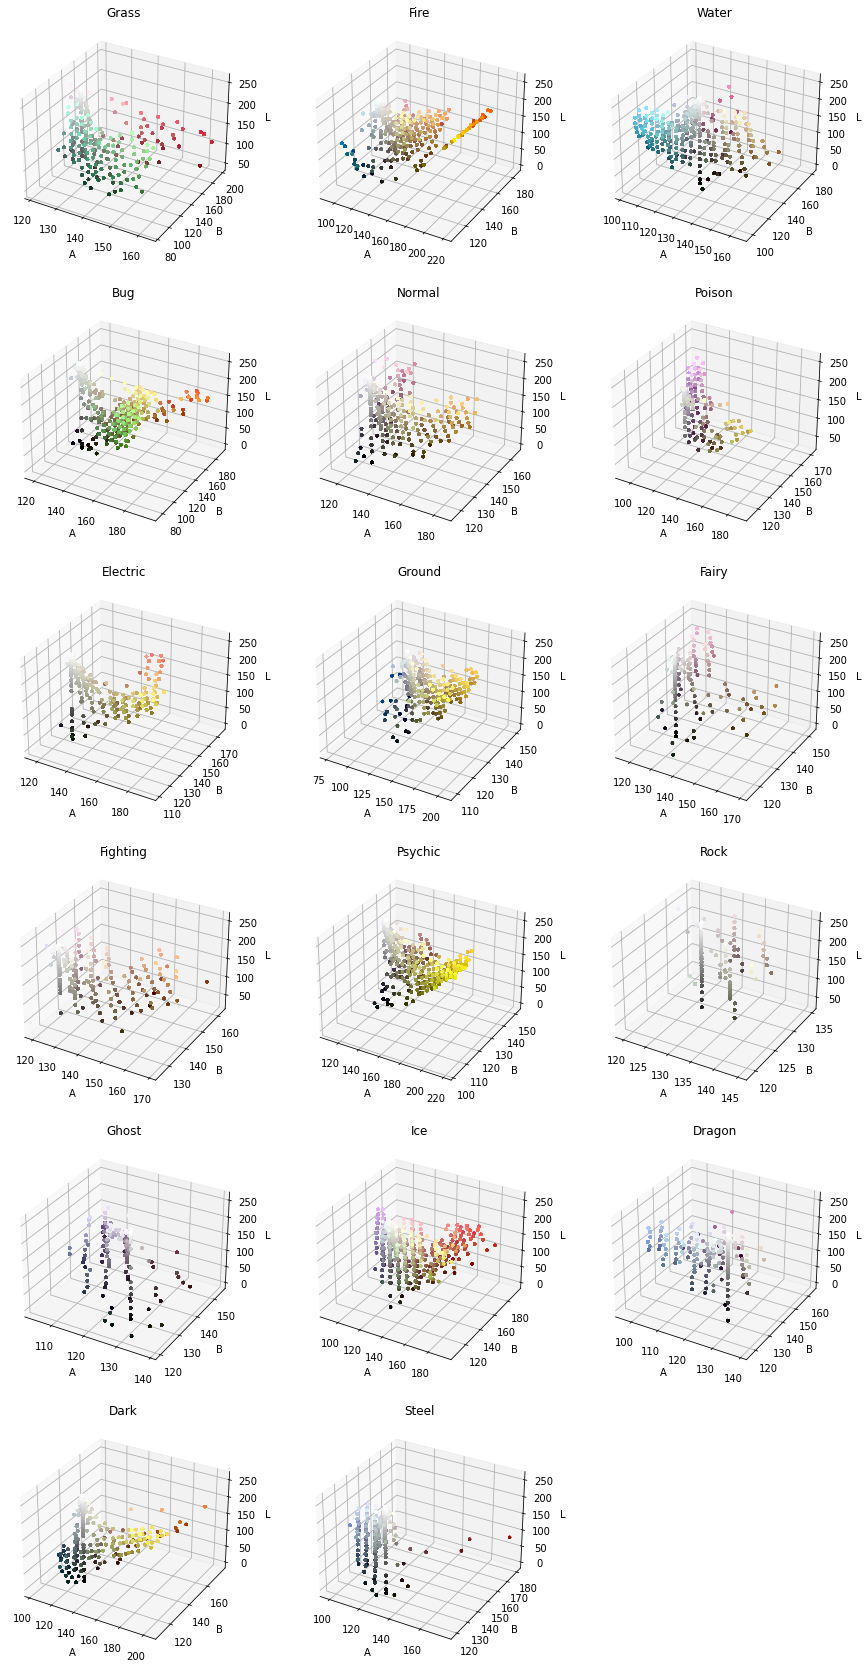

In [19]:
LAB_analysis(type_to_pokemon_list, False)

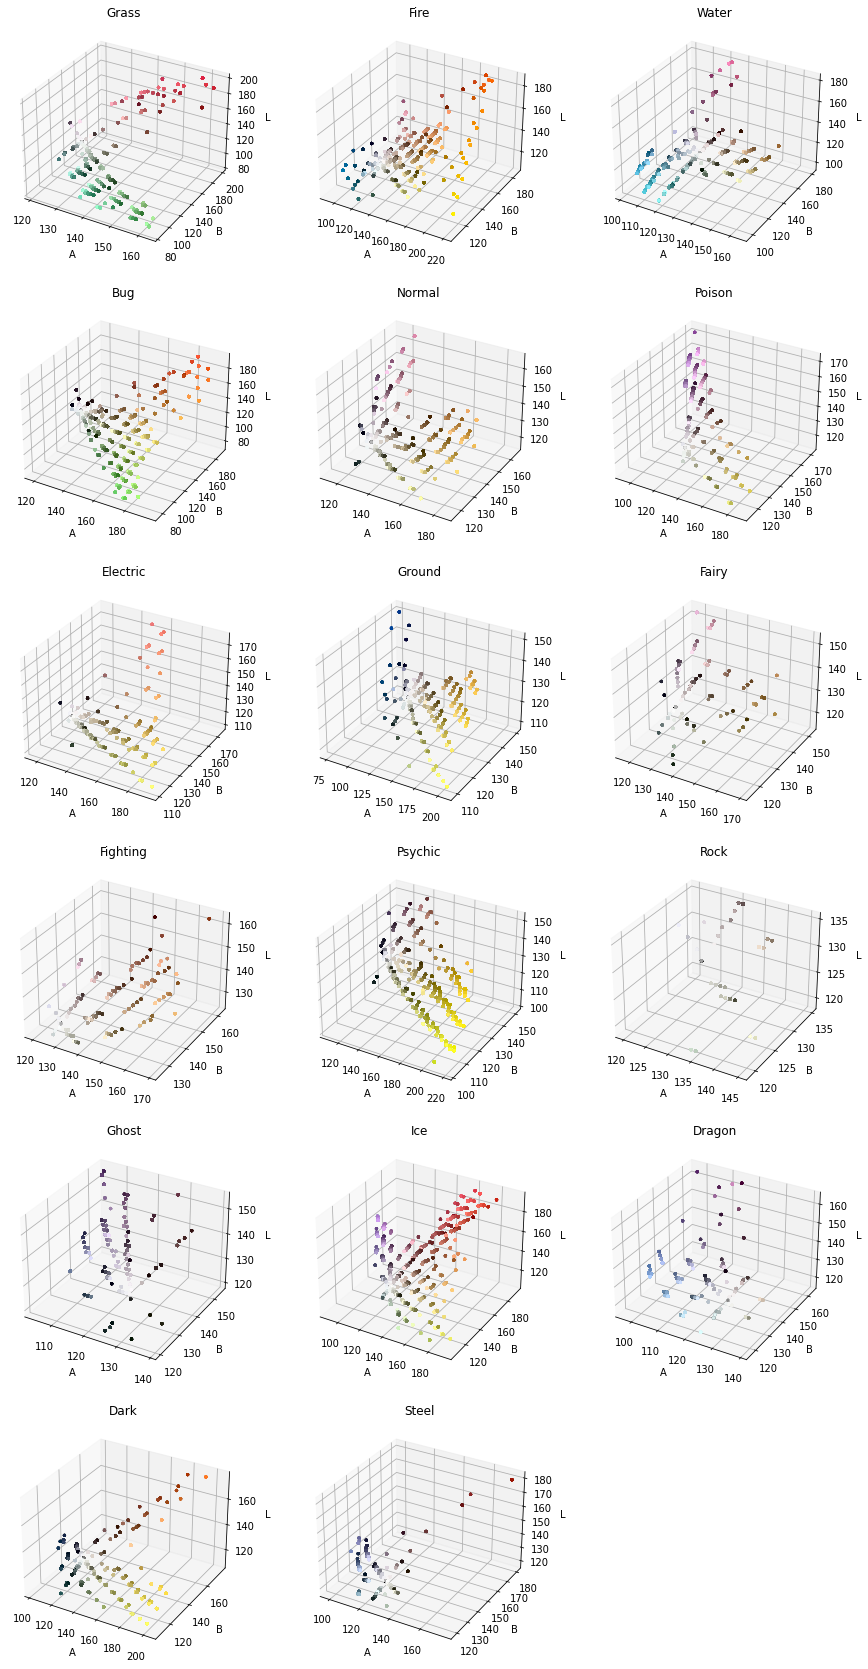

In [20]:
LAB_analysis(type_to_pokemon_list, True)